In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Определяем константы для 76As и 37Ar

In [2]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33
log_ft_76As=5.0

Q_EC_37Ar=0.81387 #in MeV
Z_37Ar=18
log_ft_37Ar=5.1

g_a_g_v=1.297 #ratio of vector and axial coupling constants

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

Ферми функция по Инжечику: $F(Z, {\epsilon}_e)= \frac{y}{1-e^{-y}}$, где $ {y} = \frac{2{\pi}Z\alpha}{\pi_e} $

In [6]:
def Columb_func(Pi_e, Z):
    #ферми функция по Инжечику
    if Pi_e>0:
        y_k=(2*math.pi*Z)/(Pi_e*137)
        return y_k/(1-math.exp(-y_k))
    else: return 0

Ферми функция по Бакалу: $F(Z, {\epsilon}_e)= \frac{y}{1-e^{-y}}$, где $ {y} = \frac{2{\pi}Z\alpha \epsilon_e}{\pi_e} $

In [7]:
def Columb_func_Bahcall(Pi_e, Z, e_e):
    #ферми функция по Бакалу
    if Pi_e>0:
        y_k=(2*math.pi*Z*e_e)/(Pi_e*137)
        return y_k/(1-math.exp(-y_k))
    else: return 0

Ферми функция из таблиц Суслова

In [8]:
Fermi_func_data = pd.read_csv('../../fermi_func_tables/Interp.csv')
#Fermi_func.info()

def Fermi_func(e_e):
    #input привиденная энергия электрона
    return np.interp(x = (e_e-0.511)*0.511, xp = Fermi_func_data['E_meV'], 
                     fp = Fermi_func_data['F_value'])

Сечение по Инжечику $\sigma_k=\frac{0.2625}{10^{log ft}}\frac{2J_k+1}{2J_i+1} \epsilon_e \pi_e F(Z, \epsilon_e)10^{-40}$ $cm^2$ 

In [9]:
def sigma_k_Inzh_Suslov(J_k, J_i, E_nu, E_k, log_ft, Z, Q_EC):
    #сечение k-го возб. состояния по Инжечику. J_k - угл. момент k-го возб. состояния
    #промежуточного ядра, J_i - угл. мом. первичного ядра. E_k - энергия возб. k-го состояния
    e_e=e_e_func(E_nu, E_k, Q_EC) #привиденная энергия
    Pi_e=Pi_e_func(e_e)#привиденный импульс
    F_col=Fermi_func(e_e)#ферми функция
    return 0.2625*( (2*J_k+1)/(2*J_i+1) )*e_e*Pi_e*F_col/(math.pow(10, log_ft))*math.pow(10, -40)

In [10]:
def sigma_k_Inzh_Bahcall(J_k, J_i, E_nu, E_k, log_ft, Z, Q_EC):
    #сечение k-го возб. состояния по Инжечику с бакаловской ферми функцией
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    F_col=Columb_func_Bahcall(Pi_e, Z, e_e)
    #print(e_e,Pi_e,F_col)
#    return 0.2625*(2*J_k+1)*e_e*Pi_e*F_col/(math.pow(10, log_ft))*math.pow(10, -40)
    return 0.2625*( (2*J_k+1)/(2*J_i+1) )*e_e*Pi_e*F_col/(math.pow(10, log_ft))*10**(-40)

In [11]:
def sigma_k_Inzh_Inzh(J_k, J_i, E_nu, E_k, log_ft, Z, Q_EC):
    #сечение k-го возб. состояния по Инжечику. J_k - угл. момент k-го возб. состояния
    #промежуточного ядра, J_i - угл. мом. первичного ядра. E_k - энергия возб. k-го состояния
    e_e=e_e_func(E_nu, E_k, Q_EC) #привиденная энергия
    Pi_e=Pi_e_func(e_e)#привиденный импульс
    F_col=Columb_func(Pi_e, Z)#ферми функция
    return 0.2625*( (2*J_k+1)/(2*J_i+1) )*e_e*Pi_e*F_col/(math.pow(10, log_ft))*math.pow(10, -40)

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [12]:
def sigma_k_Ejiri_Suslov(E_nu, E_k, BGT_k, Z, Q_EC):
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    F_col=Fermi_func(e_e)#ферми функция
    #F_col=Columb_func_Bahcall(Pi_e, Z, e_e)
    return e_e*Pi_e*F_col*math.pow(0.511,2)*math.pow(g_a_g_v,2)*BGT_k*1.597*math.pow(10,-44)

In [13]:
def sigma_k_Ejiri_Bahcall(E_nu, E_k, BGT_k, Z, Q_EC):
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    #F_col=Fermi_func(e_e)#ферми функция
    F_col=Columb_func_Bahcall(Pi_e, Z, e_e)
    return e_e*Pi_e*F_col*math.pow(0.511,2)*math.pow(g_a_g_v,2)*BGT_k*1.597*math.pow(10,-44)

## Подсчет для 76As

Считываем данные по энергии возбуждения $E_x$ и $J_\pi$

In [14]:
J_k_As_max = pd.read_csv('j_data_76As_maximal_values.csv')  #для состояний с неизвестным J 
#считалось что J=1
J_k_As_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
Elevel_(keV)    126 non-null float64
Jπ_korrect      126 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 KB


In [15]:
J_k_As_Ejiri = pd.read_csv('j_data_76As_Ejiri.csv') 
J_k_As_Ejiri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 4 columns):
E_x_keV                              65 non-null float64
J_pi                                 65 non-null int64
B(GT)                                65 non-null object
all levels with B(GT)<0.1 removed    0 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.1+ KB


In [16]:
BGT=pd.read_csv('../B(GT) peaks processing/clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [17]:
BGT['B(GT)'] = BGT['B(GT)']/10

In [18]:
fluxes=pd.read_csv('../Vyborov_results/Fluxes/SumFluxes.csv', sep=';')
fluxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
energy          2000 non-null float64
sum_spectrum    2000 non-null float64
dtypes: float64(2)
memory usage: 31.3 KB


In [19]:
#E_nu_list=fluxes['energy'].values
E_nu_list=np.arange(0,10,0.01)
sum_spectrum=fluxes['sum_spectrum'].values
step_size=0.01 #MeV

In [20]:
#Зависимости сечения от энергии нейтрино для:
#метод Иджири, Ферми функция Суслова, все возб. состояния
Ej_76As_Suslov=[sum([sigma_k_Ejiri_Suslov(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                            for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
                 for E_nu in E_nu_list]
Ej_76As_Bahcall=[sum([sigma_k_Ejiri_Bahcall(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                            for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
                 for E_nu in E_nu_list]

#метод Инжечика, Ферми функция Суслова, все возб. состояния, для состояний с неизвестным J считалось что J=1
Inzh_76As_Suslov=[sum([sigma_k_Inzh_Suslov(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As_max['Jπ_korrect'].values, J_k_As_max['Elevel_(keV)'].values)])
                 for E_nu in E_nu_list]
#метод Инжечика, Ферми функция Бакала, все возб. состояния, для состояний с неизвестным J считалось что J=1
Inzh_76As_Bahcall=[sum([sigma_k_Inzh_Bahcall(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As_max['Jπ_korrect'].values, J_k_As_max['Elevel_(keV)'].values)])
                 for E_nu in E_nu_list]
#метод Инжечика, Ферми функция Инжечика, все возб. состояния, для состояний с неизвестным J считалось что J=1
Inzh_76As_Inzh=[sum([sigma_k_Inzh_Inzh(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As_max['Jπ_korrect'].values, J_k_As_max['Elevel_(keV)'].values)])
                 for E_nu in E_nu_list]

In [21]:
#метод Инжечика, Ферми функция Суслова, J_pi из статьи Иджири
Inzh_76As_Suslov_Ejiri=[sum([sigma_k_Inzh_Suslov(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As_Ejiri['J_pi'].values, J_k_As_Ejiri['E_x_keV'].values)])
                 for E_nu in E_nu_list]

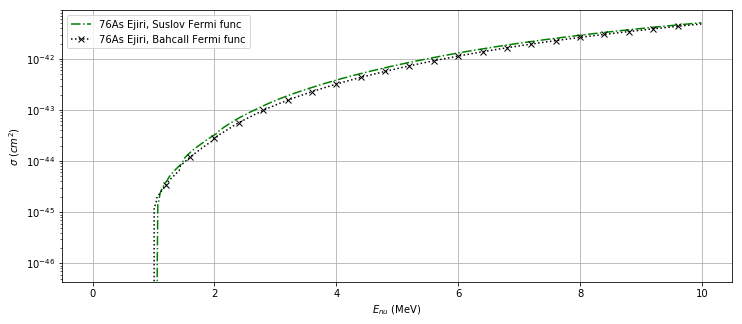

In [22]:
plt.figure(figsize=(12,5))
#plt.plot(E_nu_list, Inzh_76As_Suslov, c='red', ls=':', label='76As Inzh, Suslov Fermi func')
#plt.plot(E_nu_list, Inzh_76As_Bahcall, c='blue',ls='-', label='76As Inzh, Bahcall Fermi func')
#plt.plot(E_nu_list, Inzh_76As_Inzh, c='violet',ls='--', label='76As Inzh, Inzh Fermi func')
#plt.plot(E_nu_list, Inzh_76As_Suslov_Ejiri, c='orange', ls='--', label='76As Inzh, Suslov Fermi func, J_pi form Ejiri')

plt.plot(E_nu_list, Ej_76As_Suslov, c='green',ls='-.', label='76As Ejiri, Suslov Fermi func')
plt.plot(E_nu_list, Ej_76As_Bahcall, c='black',ls=':',marker='x', markevery=40, label='76As Ejiri, Bahcall Fermi func')
plt.grid()
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.xscale('log')

### R calculation

In [23]:
fluxes=pd.read_csv('../Vyborov_results/Fluxes/SumFluxes.csv', sep=';')
fluxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
energy          2000 non-null float64
sum_spectrum    2000 non-null float64
dtypes: float64(2)
memory usage: 31.3 KB


In [24]:
E_nu_list=fluxes['energy'].values
sum_spectrum=fluxes['sum_spectrum'].values
step_size=0.01 #MeV

In [25]:
Ej_76As_Bahcall=[sum([sigma_k_Ejiri_Bahcall(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                            for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
                 for E_nu in E_nu_list]

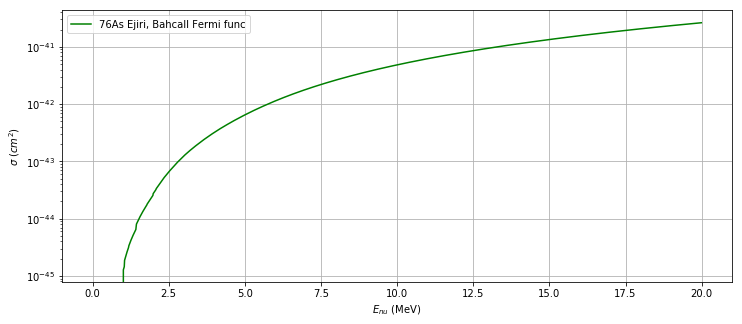

In [26]:
plt.figure(figsize=(12,5))
plt.plot(E_nu_list, Ej_76As_Bahcall, c='green', label='76As Ejiri, Bahcall Fermi func')
plt.grid()
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')

In [27]:
def oscillation(E_nu):
    return 0.336+0.117*np.exp((-E_nu-0.1)/4.82)+0.119*np.exp((-E_nu-0.1)/4.88)

In [28]:
#Without pep
Ejiri_no_pep = sum(sum_spectrum*Ej_76As_Bahcall*step_size)  * math.pow(10,36)
print(Ejiri_no_pep)

10.5317819131


In [29]:
#pep
pep_ampl=1.453e8
pep_en=1.442 #MeV

Ejiri_pep=(pep_ampl*math.pow(10,36))*sum([
    sigma_k_Ejiri_Bahcall(pep_en, E_k, BGT_k, Z_76As, Q_EC_76As) for (BGT_k, E_k) 
    in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
print(Ejiri_pep)

1.17475110534


In [30]:
print('Total R=', Ejiri_no_pep+Ejiri_pep)

Total R= 11.7065330184


In [31]:
atom_num = 7.9*math.pow(10,27)
time = 3600*24*365

In [32]:
(Ejiri_no_pep+Ejiri_pep) / math.pow(10,36) * atom_num * time

2.9165000796233205